# Research Question
#### Can changes in PCA yield factors or macro variables predict the relative performance of long- vs short-maturity bonds?

Predictor space: Yield curve level/slope/curvature (from PCA) + macro variables (inflation, GDP, unemployment).

Target: Future excess return of long-end minus short-end bond portfolio (e.g., 10Y vs 2Y).

#### Step 1: Data Preparation

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Tuple
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [8]:
data_m = pd.read_csv("../../../data/processed/us_macro_monthly.csv", index_col=0, parse_dates=True)
factors = pd.read_csv("../../../data/processed/yield_curve_factors.csv", index_col=0, parse_dates=True)

# merge and keep monthly index
df = pd.concat([data_m, factors], axis=1).sort_index()
df = df.asfreq("ME")
df = df.dropna()
df

,DFF,DGS2,DGS10,CPIAUCSL,M2SL,GDPC1,UNRATE,spread_10y_2y,inflation_yoy,m2_growth_yoy,gdp_growth_yoy,real_dff,log_gdp,log_m2,USREC,PC1_Level,PC2_Slope,PC3_Curvature
1982-01-31,13.220645,14.568000,14.594000,94.400,1770.4,7295.631,8.6,0.026000,8.256881,10.174871,-2.190515,4.963764,8.895031,7.478961,1.0,21.019689,-0.077729,0.042877
1982-02-28,14.779286,14.823333,14.425556,94.700,1774.5,7295.631,8.9,-0.397778,7.613636,9.625008,-2.190515,7.165649,8.895031,7.481274,1.0,21.614308,0.998339,0.707984
1982-03-31,14.677742,14.194348,13.861304,94.700,1786.5,7295.631,9.0,-0.333043,6.884876,9.159233,-2.190515,7.792866,8.895031,7.488014,1.0,20.100473,0.813701,0.386244
1982-04-30,14.937000,14.202381,13.871905,95.000,1803.9,7328.912,9.3,-0.330476,6.621773,8.721070,-1.010745,8.315227,8.899582,7.497706,1.0,20.068455,0.919863,0.310112
1982-05-31,14.454839,13.777000,13.622500,95.900,1815.4,7328.912,9.4,-0.154500,6.911929,9.085446,-1.010745,7.542910,8.899582,7.504061,1.0,19.309262,0.559139,0.215721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,4.475161,4.225714,4.391429,317.603,21441.8,23586.542,4.1,0.165714,2.872366,3.576570,2.399788,1.602795,10.068432,9.973098,0.0,-0.944962,1.443090,0.090427
2025-01-31,4.330000,4.271905,4.629048,319.086,21510.9,23548.210,4.0,0.357143,2.999413,3.551709,2.019273,1.330587,10.066805,9.976315,0.0,-0.646594,1.164298,0.103912
2025-02-28,4.330000,4.210000,4.451053,319.775,21584.2,23548.210,4.1,0.241053,2.814270,3.466260,2.019273,1.515730,10.066805,9.979717,0.0,-0.898534,1.318041,0.103299
2025-03-31,4.330000,3.970000,4.280476,319.615,21656.9,23548.210,4.2,0.310476,2.405585,3.616078,2.019273,1.924415,10.066805,9.983079,0.0,-1.232613,1.387224,0.285815


In [9]:
df.columns

Index(['DFF', 'DGS2', 'DGS10', 'CPIAUCSL', 'M2SL', 'GDPC1', 'UNRATE',
       'spread_10y_2y', 'inflation_yoy', 'm2_growth_yoy', 'gdp_growth_yoy',
       'real_dff', 'log_gdp', 'log_m2', 'USREC', 'PC1_Level', 'PC2_Slope',
       'PC3_Curvature'],
      dtype='object')

------------------------------------------------------------
Goal: Trade a curve tilt (10Y vs 2Y) using PCA factors + macro
- Target: next-month steepener return r(10Y) - r(2Y)
- Predictors: PC2_Slope, PC3_Curvature, inflation_yoy, gdp_growth_yoy, UNRATE, lagged target
- Expanding-window OOS fit (OLS baseline)
- Positions: (a) sign(pred) and (b) continuous pred/sigma (clipped)
- Metrics: OOS R^2, Sharpe, MaxDD, hit rate, turnover
------------------------------------------------------------

In [23]:
# =========================
# Upgrades for Bond Tilt
# =========================

import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from dataclasses import dataclass
from typing import List, Dict, Tuple

# ---------- Utilities (same as before; keep your versions if you already have them) ----------
def annualized_sharpe(monthly_returns: pd.Series) -> float:
    m = monthly_returns.dropna()
    if len(m) < 2: return np.nan
    return np.sqrt(12) * m.mean() / m.std(ddof=1)

def max_drawdown(series: pd.Series) -> Tuple[float, float]:
    wealth = (1 + series.fillna(0)).cumprod()
    roll_max = wealth.cummax()
    dd = wealth / roll_max - 1.0
    mdd = dd.min()
    # duration (years)
    cur, best = 0, 0
    for i in range(len(wealth)):
        if wealth.iloc[i] == roll_max.iloc[i]:
            best = max(best, cur); cur = 0
        else:
            cur += 1
    best = max(best, cur)
    return float(mdd), float(best/12)

def oos_r2(realized: pd.Series, predicted: pd.Series) -> float:
    aligned = pd.concat({"r": realized, "p": predicted}, axis=1).dropna()
    if aligned.empty: return np.nan
    r, p = aligned["r"], aligned["p"]
    mean_bmk = r.expanding(min_periods=1).mean().shift(1)
    a2 = pd.concat({"r": r, "p": p, "m": mean_bmk}, axis=1).dropna()
    num = ((a2["r"] - a2["p"])**2).sum()
    den = ((a2["r"] - a2["m"])**2).sum()
    return 1 - num/den if den > 0 else np.nan

def turnover(positions: pd.Series) -> float:
    p = positions.dropna()
    if len(p) < 2: return np.nan
    return p.diff().abs().dropna().mean()

# ---------- Return approximation (unchanged) ----------
def approximate_bond_return(yield_series: pd.Series, dur: float, freq: int = 12) -> pd.Series:
    y = yield_series.astype(float)            # decimal
    dy = y.diff()
    carry = y.shift(1) / freq                 # use start-of-month y
    price_change = -dur * dy
    return carry + price_change

# ---------- NEW: DV01-neutral steepener target ----------
def dv01_neutral_weights(dur_short: float, dur_long: float) -> Tuple[float, float]:
    """
    Returns (w_long, w_short) BEFORE normalization such that:
      w_long * Dur_long  ==  w_short * Dur_short
    Choose proportional weights: w_long = Dur_short, w_short = Dur_long
    """
    return dur_short, dur_long

def normalize_weights(w_long: float, w_short: float) -> Tuple[float, float]:
    s = abs(w_long) + abs(w_short)
    return w_long/s, w_short/s

def build_steepener_target_dv01(df: pd.DataFrame,
                                y2_col: str = "DGS2",
                                y10_col: str = "DGS10",
                                dur_2y: float = 1.9,
                                dur_10y: float = 8.5) -> pd.DataFrame:
    """Create DV01-neutral steepener target using duration-based weights."""
    out = df.copy()
    y2 = out[y2_col] / 100.0
    y10 = out[y10_col] / 100.0
    out["ret_2y"] = approximate_bond_return(y2, dur=dur_2y)
    out["ret_10y"] = approximate_bond_return(y10, dur=dur_10y)
    # raw dv01-neutral weights then normalized for comparability
    w_long_raw, w_short_raw = dv01_neutral_weights(dur_2y, dur_10y)
    w10, w2 = normalize_weights(w_long_raw, w_short_raw)  # w10 applies to 10Y long, w2 to 2Y short
    # DV01-neutral steepener return (long 10Y, short 2Y)
    out["ret_steepener_dv01"] = w10 * out["ret_10y"] - w2 * out["ret_2y"]
    out["ret_steepener_lag1"] = out["ret_steepener_dv01"].shift(1)
    return out

# ---------- Feature config ----------
@dataclass
class FeatureConfig:
    predictors: List[str]
    add_const: bool = True
    standardize: bool = True
    macro_lag_months: int = 1   # to reduce timing/leakage risk on macro prints

def lag_columns(df: pd.DataFrame, cols: List[str], k: int) -> pd.DataFrame:
    d = df.copy()
    for c in cols:
        if c in d.columns:
            d[c] = d[c].shift(k)
    return d

# ---------- NEW: regime interactions ----------
def add_regime_features(df: pd.DataFrame,
                        spread_col: str = "spread_10y_2y",
                        infl_col: str = "inflation_yoy",
                        infl_thresh: float = None) -> pd.DataFrame:
    d = df.copy()
    d["inv_dummy"] = (d[spread_col] < 0).astype(int)
    if infl_thresh is None:
        infl_thresh = d[infl_col].median()
    d["high_infl_dummy"] = (d[infl_col] > infl_thresh).astype(int)
    # interactions with PCA slope/curvature
    if "PC2_Slope" in d and "PC3_Curvature" in d:
        d["PC2xINV"] = d["PC2_Slope"] * d["inv_dummy"]
        d["PC3xHINF"] = d["PC3_Curvature"] * d["high_infl_dummy"]
    return d

# ---------- Design matrices ----------
def make_feature_matrix(df: pd.DataFrame, cfg: FeatureConfig) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Target = next-month DV01-neutral steepener return.
    Predictors = cfg.predictors (macro columns will be lagged by cfg.macro_lag_months).
    """
    y = df["ret_steepener_dv01"].shift(-1)

    # Split predictors into macro vs non-macro if you want distinct lagging.
    # Here we conservatively lag ALL non-return macro-ish columns except lags already present.
    macro_like = {"inflation_yoy","gdp_growth_yoy","UNRATE","M2SL","m2_growth_yoy","real_dff","USREC"}
    X = df[cfg.predictors].copy()
    cols_to_lag = [c for c in X.columns if c in macro_like and not c.endswith("_lag1")]
    if cfg.macro_lag_months > 0 and len(cols_to_lag) > 0:
        X.loc[:, cols_to_lag] = X[cols_to_lag].shift(cfg.macro_lag_months)

    return X, y

# ---------- Expanding-window OLS ----------
def expanding_window_ols_oos(X: pd.DataFrame, y: pd.Series, start_date: str,
                             standardize: bool = True, add_const: bool = True) -> pd.DataFrame:
    data = pd.concat({"y": y, "X": X}, axis=1).dropna(how="any")
    if isinstance(start_date, str):
        data = data.loc[data.index >= pd.to_datetime(start_date)]

    # Use full aligned mask for train history
    full = pd.concat({"y": y, "X": X}, axis=1)
    mask_full = full.dropna(how="any").index

    preds, reals, idxs = [], [], []
    for t in data.index:
        train_idx = mask_full[mask_full < t]
        if len(train_idx) < 36:  # require 3 years of history
            continue

        X_train, y_train = X.loc[train_idx].copy(), y.loc[train_idx].copy()
        X_t, y_t = X.loc[[t]].copy(), y.loc[t]

        if standardize:
            scaler = StandardScaler()
            X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
            X_t = pd.DataFrame(scaler.transform(X_t), index=X_t.index, columns=X_t.columns)

        X_train_fit = sm.add_constant(X_train) if add_const else X_train
        X_t_fit = sm.add_constant(X_t, has_constant="add") if add_const else X_t
        model = sm.OLS(y_train, X_train_fit).fit()
        preds.append(float(model.predict(X_t_fit).iloc[0]))
        reals.append(float(y_t))
        idxs.append(t)

    return pd.DataFrame({"pred": preds, "realized": reals}, index=pd.DatetimeIndex(idxs))

# ---------- NEW: Hysteresis for positions ----------
def hysteresis_positions(pred: pd.Series, threshold: float = 0.0, confirm: int = 2) -> pd.Series:
    """
    Only flip after 'confirm' consecutive months beyond threshold.
    Returns positions in {-1, 0, +1}.
    """
    p = pred.copy()
    sig = pd.Series(0.0, index=p.index)
    desired = (p > threshold).astype(int) - (p < -threshold).astype(int)  # {-1,0,+1}

    cur = 0.0
    streak = 0
    prev_desired = 0
    for t in p.index:
        d = int(desired.loc[t])
        if d == 0:
            streak = 0
            sig.loc[t] = cur
            continue
        if d == prev_desired:
            streak += 1
        else:
            streak = 1
        if streak >= confirm and d != cur:
            cur = float(d)
        sig.loc[t] = cur
        prev_desired = d
    return sig

# ---------- NEW: Realized-vol targeting ----------
def vol_target_positions(base_pos: pd.Series,
                         realized_target_returns: pd.Series,
                         ann_vol_target: float = 0.10,
                         lookback: int = 36,
                         max_leverage: float = 2.0) -> pd.Series:
    """
    Scale position so that realized portfolio vol ≈ ann_vol_target.
    Uses rolling realized vol of the *target* (ret_steepener_dv01).
    """
    monthly_target = ann_vol_target / np.sqrt(12)
    sigma = realized_target_returns.rolling(lookback).std()
    scale = (monthly_target / sigma).clip(upper=max_leverage)
    return (base_pos * scale).fillna(0.0)

# ---------- Strategy PnL ----------
def pnl_from_positions(positions: pd.Series, realized_target: pd.Series, tc_bps: float = 0.0) -> pd.Series:
    pos = positions.shift(1).fillna(0.0)  # trade at month-end for next month
    raw = pos * realized_target
    tc = (tc_bps/10000.0) * positions.diff().abs().fillna(0.0)
    return raw - tc

# ---------- Baselines & subperiods ----------
def baseline_always(returns: pd.Series, side: str = "steepener") -> pd.Series:
    sign = 1.0 if side == "steepener" else -1.0
    return (sign * returns).rename(f"baseline_{side}")

def baseline_inversion_hold(returns: pd.Series, spread: pd.Series, hold_months: int = 6) -> pd.Series:
    """
    When spread < 0 at t, hold a 're-steepener' (+1) for next hold_months; else 0.
    """
    inv = (spread < 0).astype(int)
    sig = inv.rolling(window=1).apply(lambda x: 1.0 if x.iloc[0] == 1 else 0.0)
    # Expand to multi-month hold
    for k in range(1, hold_months):
        sig = sig.combine_first(inv.shift(k))
    sig = sig.fillna(0.0).clip(0,1)
    return (sig.shift(1).fillna(0.0) * returns).rename("baseline_inversion")

def evaluate_series(r: pd.Series) -> Dict[str, float]:
    mdd, mdd_yrs = max_drawdown(r)
    return {
        "sharpe": annualized_sharpe(r),
        "max_drawdown": mdd,
        "max_dd_years": mdd_yrs
    }

def subperiod_metrics(series: pd.Series, cuts: List[Tuple[str,str]]) -> Dict[str, Dict[str,float]]:
    out = {}
    for (a,b) in cuts:
        sub = series.loc[a:b]
        out[f"{a}_{b}"] = evaluate_series(sub)
    return out

# ---------- End-to-end run with upgrades ----------
def run_bond_tilt_backtest_upgraded(df: pd.DataFrame,
                                    start_date: str = "1990-01-01",
                                    predictors: List[str] = None,
                                    tc_bps: float = 0.0,
                                    ann_vol_target: float = 0.10,
                                    hysteresis_confirm: int = 2,
                                    hysteresis_threshold: float = 0.0) -> Dict[str, Dict]:
    """
    Pipeline:
      1) DV01-neutral steepener target
      2) Regime features + macro lags
      3) OOS predictions (OLS)
      4) Hysteresis + vol targeting
      5) Baselines & subperiods
    """

    # 1) Target
    data = build_steepener_target_dv01(df)

    # 2) Regime features
    data = add_regime_features(data, spread_col="spread_10y_2y", infl_col="inflation_yoy")

    # Default predictors if none provided
    if predictors is None:
        predictors = [
            "PC2_Slope", "PC3_Curvature",
            "PC2xINV", "PC3xHINF",    # interactions
            "inflation_yoy", "gdp_growth_yoy", "UNRATE",
            "ret_steepener_lag1"
        ]

    cfg = FeatureConfig(predictors=predictors, add_const=True, standardize=True, macro_lag_months=1)
    X, y = make_feature_matrix(data, cfg)

    # 3) OOS predictions
    oos = expanding_window_ols_oos(X, y, start_date=start_date,
                                   standardize=cfg.standardize, add_const=cfg.add_const)

    # 4) Strategies
    pred, realized = oos["pred"], oos["realized"]

    # 4a) Hysteresis sign positions
    pos_sign_hyst = hysteresis_positions(pred, threshold=hysteresis_threshold, confirm=hysteresis_confirm)

    # 4b) Vol-targeted (apply on top of sign+hysteresis)
    # Use realized target returns aligned to oos index
    realized_target = data["ret_steepener_dv01"].reindex(oos.index)
    pos_sign_hyst_vt = vol_target_positions(pos_sign_hyst, realized_target,
                                            ann_vol_target=ann_vol_target, lookback=36, max_leverage=2.0)

    # 4c) Scaled by pred/sigma (previous method), with hysteresis disabled (optional compare)
    sigma_pred = pred.rolling(36).std()
    pos_scaled = (pred / sigma_pred).clip(-1, 1).fillna(0.0)

    # 5) PnL
    pnl_sign_hyst_vt = pnl_from_positions(pos_sign_hyst_vt, realized_target, tc_bps=tc_bps)
    pnl_scaled = pnl_from_positions(pos_scaled, realized_target, tc_bps=tc_bps)

    # 6) Metrics
    def pack_metrics(pnl, pos):
        mdd, mdd_yrs = max_drawdown(pnl)
        return {
            "oos_r2": oos_r2(realized, pred),
            "sharpe": annualized_sharpe(pnl),
            "max_drawdown": mdd,
            "max_dd_years": mdd_yrs,
            "hit_rate": (np.sign(pred) == np.sign(realized)).mean(),
            "turnover": turnover(pos)
        }

    metrics_hyst_vt = pack_metrics(pnl_sign_hyst_vt, pos_sign_hyst_vt)
    metrics_scaled  = pack_metrics(pnl_scaled, pos_scaled)

    # 7) Baselines
    base_steep = baseline_always(realized_target, side="steepener").reindex(oos.index)
    base_flat  = baseline_always(realized_target, side="flattener").reindex(oos.index)
    base_inv   = baseline_inversion_hold(realized_target, df["spread_10y_2y"].reindex(oos.index), hold_months=6)

    base_metrics = {
        "always_steepener": evaluate_series(base_steep),
        "always_flattener": evaluate_series(base_flat),
        "inversion_hold6m": evaluate_series(base_inv),
    }

    # 8) Subperiods
    cuts = [("1990-01-01","1999-12-31"), ("2000-01-01","2009-12-31"),
            ("2010-01-01","2019-12-31"), ("2020-01-01", str(oos.index[-1].date()))]
    subperiods = {
        "hyst_vt": subperiod_metrics(pnl_sign_hyst_vt, cuts),
        "scaled":  subperiod_metrics(pnl_scaled, cuts),
        "baseline_steep": subperiod_metrics(base_steep, cuts),
        "baseline_flat":  subperiod_metrics(base_flat, cuts),
    }

    return {
        "hysteresis_voltarget": {k:v for k,v in metrics_hyst_vt.items()},
        "scaled_pred_sigma":    {k:v for k,v in metrics_scaled.items()},
        "baselines":            base_metrics,
        "series": {
            "pred": pred,
            "realized": realized,
            "pos_hyst_vt": pos_sign_hyst_vt,
            "pnl_hyst_vt": pnl_sign_hyst_vt,
            "pos_scaled": pos_scaled,
            "pnl_scaled": pnl_scaled,
            "baseline_steep": base_steep,
            "baseline_flat": base_flat,
            "baseline_inversion": base_inv,
        },
        "subperiods": subperiods
    }


In [24]:
results = run_bond_tilt_backtest_upgraded(
    df=df,                         # your monthly DataFrame
    start_date="1990-01-01",
    predictors=[
        "PC2_Slope","PC3_Curvature","PC2xINV","PC3xHINF",
        "inflation_yoy","gdp_growth_yoy","UNRATE",
        "ret_steepener_lag1"
    ],
    tc_bps=0.5,                    # simple turnover cost
    ann_vol_target=0.10,           # 10% annual volatility
    hysteresis_confirm=2,          # need 2 consecutive months to flip
    hysteresis_threshold=0.0
)

print("Hysteresis + VolTarget:", results["hysteresis_voltarget"])
print("Scaled (pred/sigma):  ", results["scaled_pred_sigma"])
print("Baselines:", results["baselines"])

Hysteresis + VolTarget: {'oos_r2': np.float64(-0.021411125976987355), 'sharpe': np.float64(1.711414990891386), 'max_drawdown': -0.05168927691471581, 'max_dd_years': 9.666666666666666, 'hit_rate': np.float64(0.7139479905437353), 'turnover': np.float64(0.08056872037914692)}
Scaled (pred/sigma):   {'oos_r2': np.float64(-0.021411125976987355), 'sharpe': np.float64(1.702904243226761), 'max_drawdown': -0.02630889857747898, 'max_dd_years': 9.75, 'hit_rate': np.float64(0.7139479905437353), 'turnover': np.float64(0.0734649455948254)}
Baselines: {'always_steepener': {'sharpe': np.float64(-2.051494577010329), 'max_drawdown': -0.4832560886361543, 'max_dd_years': 35.166666666666664}, 'always_flattener': {'sharpe': np.float64(2.051494577010329), 'max_drawdown': -0.03270863695027959, 'max_dd_years': 10.25}, 'inversion_hold6m': {'sharpe': np.float64(-1.0148434239669901), 'max_drawdown': -0.14762813321839352, 'max_dd_years': 35.0}}


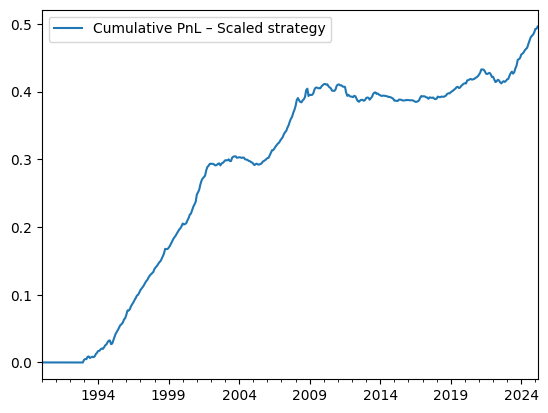

In [25]:
results["series"]["pnl_scaled"].cumsum().plot(label="Cumulative PnL – Scaled strategy")
plt.legend()
plt.show()